### Elaborate distance measure for cinema clustering (work in progress...)

In [ ]:
def element_wise_distance(a, b):
    if len(a) != len(b):
        raise Exception('Sequences must have the same length.')
        
    m = a.count(1)
    n = b.count(1)
    
    if n == 0:
        return m
    
    if m == 0:
        return n
    
    distance = 0    
    for i, x in enumerate(a):
        if x == 1:
            one_element_distance = 0
            for j, y in enumerate(b):
                if y == 1:
                    one_element_distance += (i - j)
            distance += (one_element_distance / n)
    
    return abs(distance / m)


def hamming_distance(a, b):
    if len(a) != len(b):
        raise Exception('Sequences must have the same length.')
    
    distance = 0
    for x, y in zip(a, b):
        distance += (x != y)
    
    return distance / a.count(1)


def combined_distance(a, b):
    if len(a) != len(b):
        raise Exception('Sequences must have the same length.')
    
    n = len(a)
    return 0.5 * (element_wise_distance(a, b) + hamming_distance(a, b))

In [ ]:
# Tests
a = [1, 1, 1, 0, 0, 0, 1, 1, 1]
b = [0, 0, 1, 1, 1, 1, 0, 0, 0]

print('Distance between: %s and %s = %.2f' % (str(a), str(b), combined_distance(a, b)))

### Load data from PostgreSQL database

In [1]:
import psycopg2
import pandas as pd

connection = psycopg2.connect(dbname='cinema', user='josephkott', password='')
cursor = connection.cursor()

# Test PostgreSQL connection
cursor.execute('SELECT * FROM films_showing')
print(cursor.fetchone())

(84, 40, '', False, datetime.date(1929, 1, 4), datetime.date(1929, 1, 6), '', '4', '', '', 4, 'Рампа (Ленинград) - Одиннадцать чертей / Die Elf Teufel [Германия, 1927] 1929-01-04 - 1929-01-06', 3, 7)


### Extract showings for all cinema

In [2]:
cursor.execute('SELECT id, name FROM films_cinema')
id, name = cursor.fetchone()
print('Cinema id: %d, name: %s' % (id, name))

Cinema id: 3, name: Ампир


In [3]:
cursor.execute('SELECT cinema_id, film_id, date_from, date_to FROM films_showing')
showings = cursor.fetchall()
print('Total amount of showings: %d' % len(showings))

Total amount of showings: 2117


### Create cinama showings map

In [4]:
class Showing:
    def __init__(self, film_id, date_from, date_to):
        self.film_id = film_id
        self.date_from = date_from
        self.date_to = date_to
    
    def convert(self):
        pass
    
    def __repr__(self):
        return '%s: %s - %s' % (
            self.film_id,
            self.date_from.strftime('%Y/%m/%d'),
            self.date_to.strftime('%Y/%m/%d')
        )

In [5]:
cinema_showings = {}
for showing in showings:
    cinema_id, film_id, date_from, date_to = showing
    cinema_showings.setdefault(cinema_id, [])
    cinema_showings[cinema_id].append(Showing(film_id, date_from, date_to))

### Compute distance between two cinemas

In [6]:
def common_films_similarity(showings_a, showings_b):
    films_a = {x.film_id for x in showings_a}
    films_b = {x.film_id for x in showings_b}
    
    films_common = films_a.intersection(films_b)
    similarity = len(films_common)
    return similarity

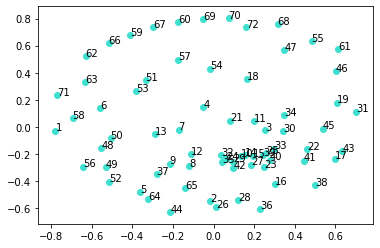

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import manifold
from sklearn import decomposition

ids = list(cinema_showings.keys())
similarity_matrix = np.zeros((len(ids), len(ids)))

for i, id_a in enumerate(cinema_showings):
    for j, id_b in enumerate(cinema_showings):
        if i == j:
            similarity_matrix[i, j] = None
        else:
            similarity_matrix[i, j] = common_films_similarity(
                cinema_showings[id_a],
                cinema_showings[id_b]
            )

norm = similarity_matrix[~np.isnan(similarity_matrix)].max()
distance_matrix = 1 - (similarity_matrix / norm)
np.fill_diagonal(distance_matrix, 0)

mds = manifold.MDS(n_components=2, dissimilarity='precomputed', max_iter=3000, eps=1e-9)
pos = mds.fit_transform(distance_matrix)

fig, ax = plt.subplots()
ax.scatter(pos[:, 0], pos[:, 1], color='turquoise', label='MDS')

for i, cinema_id in enumerate(ids):
    ax.annotate(str(cinema_id), (pos[i, 0], pos[i, 1]))